In [28]:
palette = ['#3B8EA1', '#B84D4A', '#6F5B9A', '#B59F8E', '#D96B9A', '#A3A3A3', '#D88F3B', '#4C9F4A']
from pathlib import Path
computational_data = Path("..") / "data" / "other_data" / "computational_data"
variant_scores = Path("..") / "data" / "processed_scores"
mrna_data = Path("..") / "data" / "other_data" / "mrna_data"
pdb = Path("..") / "data" / "other_data" / "structural_data"
figure = Path("..") / "figures"
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from scipy.stats import linregress
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
score = pd.read_csv(f"{variant_scores}\\lowADSL_dox+_fitness_score.csv")
score = score[score["variant_type"]=="missense"].groupby("position")["fitness_score"].median().reset_index()
conserv = pd.read_csv(f"{computational_data}\\ADSL_conservation.csv")[["position","conservation"]]

In [15]:
df = score.merge(conserv, on = "position")
df.corr(method = "spearman")

,position,fitness_score,conservation
position,1.000000,-0.002843,-0.102178
fitness_score,-0.002843,1.000000,-0.624978
conservation,-0.102178,-0.624978,1.000000


In [16]:
def csv_read(variant_scores = variant_scores, computational_data = computational_data):
    df = pd.read_csv(f"{variant_scores}\\ADSL_Est_Ei.csv")
    split = df["variant"].str.split(r'(\d+)', n=1, expand=True).rename(columns={0: "residue", 1: "position", 2: "change"})
    dfOne = pd.concat([split, df], axis=1)
    dfOne = dfOne[dfOne["variant_type"]=="missense"]
    dfTwo = dfOne.groupby('position')["Est_Ei"].median().reset_index()
    df_location = pd.read_csv(f"{computational_data}\\ADSL_aminoacid_position.csv")
    dfTwo['position'] = dfTwo['position'].astype(int)
    df_location['position'] = df_location['position'].astype(int)
    df_master = df_location.merge(dfTwo, on = "position")
    return df_master

Text(0, 0.5, 'Amino Acid \nSubstitutions')

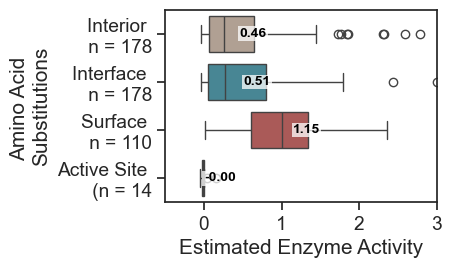

In [18]:
df = csv_read(variant_scores = variant_scores, computational_data = computational_data)
sns.set(font_scale=1.25, style="ticks", rc={"figure.figsize": (3.5, 2.5), "font.family": "Arial"})
# Create boxplot
ax = sns.boxplot(data=df, y="location", x="Est_Ei", 
                 hue="location", palette=palette[0:4], width=0.75,
                 order=["Interior", "Interface", "Surface", "Active Site"])
plt.xlim(-0.5, 3)
plt.ylabel("")
plt.xlabel("Estimated Enzyme Activity")
# Compute means
means = df.groupby("location")["Est_Ei"].mean().to_dict()
for i, loc in enumerate(["Interior", "Interface", "Surface", "Active Site"]):
    mean_val = means[loc]
    ax.text(mean_val, i, f"{mean_val:.2f}", 
            ha="left", va="center", fontsize=10, fontweight="bold", color="black",
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1))
plt.yticks([0, 1, 2, 3], [f"Interior \n n = {len(df[df['location'] == 'Interior'])}",
                          f"Interface \n n = {len(df[df['location'] == 'Interface'])}",
                          f"Surface \n n = {len(df[df['location'] == 'Surface'])}",
                          f"Active Site \n (n = {len(df[df['location'] == 'Active Site'])}"])
plt.ylabel("Amino Acid \nSubstitutions")
#plt.savefig(f"{figure}figure.svg", format="svg", bbox_inches='tight')
#plt.close()

In [19]:
def csv_read_project(variant_scores = variant_scores, computational_data = computational_data):
    df = pd.read_csv(f"{variant_scores}\\ADSL_Est_Ei.csv")
    split = df["variant"].str.split(r'(\d+)', n=1, expand=True).rename(columns={0: "residue", 1: "position", 2: "change"})
    dfOne = pd.concat([split, df], axis=1)
    dfOne = dfOne[dfOne["variant_type"]=="missense"]
    dfTwo = dfOne.groupby('position')["Est_Ei"].median().reset_index()
    dfTwo['position'] = dfTwo['position'].astype(int)
    return dfTwo

In [20]:
def pdb_writer(df, pdb):
    with open(f"{pdb}\\2J91_clean_overwrite.pdb", 'w') as pdb_file:
        for _, row in df.iterrows():
            pdb_line = f"{row['Type']:6s}{row['Atom No']:5d} {row['Atom']:4s} {row['Residue']:3s} {row['Chain']:1s}" \
                       f"{row['Residue No']:4d}    {row['X']:8.3f}{row['Y']:8.3f}{row['Z']:8.3f}" \
                       f"{row['Factor A']:6.2f}{row['Est_Ei']:6.2f}          {row['Center Atom']:2s}\n"
            pdb_file.write(pdb_line)   

In [21]:
def score_to_pdb(experiment, pdb = pdb):
    df_median = csv_read_project()
    colspecs = [(0, 6), (6, 11), (12, 16), (17, 20), (21, 22), (22, 26),
                (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78)]
    names = ['Type', 'Atom No', 'Atom', 'Residue', 'Chain', 'Residue No',
             'X', 'Y', 'Z', 'Factor A', 'Factor B', 'Center Atom']
    df_pdb = pd.read_fwf(f"{pdb}\\2J91_clean.pdb", names=names, colspecs=colspecs)
    df_pdb = df_pdb[df_pdb["Type"].isin(["ATOM", "HETATM"])]
    df_pdb["Residue No"] = df_pdb["Residue No"].astype(int)
    
    A = df_pdb[df_pdb["Chain"] == "A"]
    A_chain = A.merge(df_median, left_on="Residue No", right_on="position")
    A_chain = A_chain[["Type", "Atom No", "Atom", "Residue", "Chain", "Residue No", "X", "Y", "Z", "Factor A",
                       "Est_Ei", "Center Atom"]]
    B = df_pdb[df_pdb["Chain"] == "B"]
    B_chain = B.merge(df_median, left_on="Residue No", right_on="position")
    B_chain = B_chain[["Type", "Atom No", "Atom", "Residue", "Chain", "Residue No", "X", "Y", "Z", "Factor A",
                       "Est_Ei", "Center Atom"]]
    C = df_pdb[df_pdb["Chain"] == "C"]
    C_chain = C.merge(df_median, left_on="Residue No", right_on="position")
    C_chain = C_chain[["Type", "Atom No", "Atom", "Residue", "Chain", "Residue No", "X", "Y", "Z", "Factor A",
                       "Est_Ei", "Center Atom"]]
    D = df_pdb[df_pdb["Chain"] == "D"]
    D_chain = D.merge(df_median, left_on="Residue No", right_on="position")
    D_chain = D_chain[["Type", "Atom No", "Atom", "Residue", "Chain", "Residue No", "X", "Y", "Z", "Factor A",
                       "Est_Ei", "Center Atom"]]
    hetatm = df_pdb[df_pdb["Type"] == "HETATM"].rename(columns = {"Factor B":"Est_Ei"})
    hetatm["Est_Ei"] = 0.5
    df_main = pd.concat([A_chain, B_chain, C_chain, D_chain, hetatm], axis = 0)
    df_main[['Atom No', 'Residue No']] = df_main[['Atom No', 'Residue No']].astype(int)
    df_main[['X', 'Y', 'Z', 'Factor A', 'Est_Ei']] = df_main[['X', 'Y', 'Z', 'Factor A', 'Est_Ei']].astype(float)
    x = pdb_writer(df_main, pdb=pdb)
    return x

In [22]:
activities = pd.read_csv(f"{computational_data}\\ADSL_catalytic_residues.csv")

In [23]:
His159 = activities[activities["residue"]=="His159"].dropna()
Ser290 = activities[activities["residue"]=="Ser290"].dropna()
Ser289 = activities[activities["residue"]=="Ser289"].dropna()

Text(0.5, 1.0, 'Ser290')

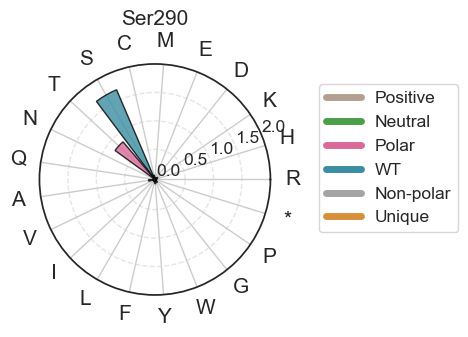

In [24]:
df = Ser290
property_order = ["WT","Positive", "Negative", "Positive", "Polar", "Non-polar", "Unique", "Neutral"]
num_amino_acids = len(df)
angles = np.linspace(0, 2 * np.pi, num_amino_acids, endpoint=False)
properties = df["type"].unique()
color_map = dict(zip(property_order, palette[:len(property_order)]))
colors = df["type"].map(color_map)
# Create polar bar chart
fig, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(polar=True))
bars = ax.bar(angles,df["Est_Ei"], color=colors, alpha=0.8, width=2*np.pi/num_amino_acids*0.8, edgecolor='black')
# Labels for amino acids
ax.set_xticks(angles)
ax.set_xticklabels(df["amino_acids"], fontsize=15)
ax.set_ylim(min(0, df["Est_Ei"].min()*1.1), df["Est_Ei"].max()*1.1)
ax.set_yticks([0, 0.5, 1, 1.5, 2])  # set the radial tick positions
ax.tick_params(axis='y', labelsize=12.5)  # set font size of the radial labels
# Add legend
handles = [plt.Line2D([0], [0], color=color_map[prop], lw=5) for prop in properties]
ax.legend(handles, properties, loc="upper right", bbox_to_anchor=(1.85, 0.95), fontsize = 12.5).set_visible(True)
# Add gridlines and title
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_title("Ser290", fontsize=15, pad=5)
#plt.savefig(f"{figure}figure.svg", format="svg", bbox_inches='tight')
#plt.close()

In [31]:
def csv_read(experiment, notstop, terminus, mrna_data = mrna_data):
    df_mrna = pd.read_csv(f"{mrna_data}\\ADSL_mrna_stability{terminus}.csv")
    df_low = pd.read_csv(f"{mrna_data}\\lowADSL_dox_codon_score.csv")
    df_high = pd.read_csv(f"{mrna_data}\\highADSL_dox_codon_score.csv")
    if notstop==True:
        if experiment == "low":
            df = df_mrna.merge(df_low, left_on = "variant", right_on = "codon")
            df = df[df["variant_type"]!="nonsense"]
        elif experiment == "high":
            df = df_mrna.merge(df_high, left_on = "variant", right_on = "codon")
            df = df[df["variant_type"]!="nonsense"]
        else:
            print("not-valid exp.")
        print("notstop")
    else:
        if experiment == "low":
            df = df_mrna.merge(df_low, left_on = "variant", right_on = "codon")
        elif experiment == "high":
            df = df_mrna.merge(df_high, left_on = "variant", right_on = "codon")
        else:
            print("not-valid exp.")
        print("all-included")
    output = df[df["codon"]!="wild-type"]
    missense = output[output["variant_type"]=="missense"]
    synonymous = output[output["variant_type"]=="synonymous"]
    print(f"terminus: {terminus}")
    print(f"dataset: {experiment}")
    return output, missense, synonymous

In [32]:
output, missense, synonymous = csv_read("high", terminus = "C", notstop = True)

notstop
terminus: C
dataset: high


In [33]:
x = synonymous["mrna_stability"]
y = synonymous["norm_score"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"r_value: {round(r_value,4)}")
print(f"p_value: {p_value}")

r_value: -0.0439
p_value: 0.9177291865101278


In [34]:
n_corr = pd.DataFrame({
    "dataset": ["low_miss", "low_syn", "high_miss", "high_syn"],
    "terminus": ["N", "N", "N", "N"],
    "r_value": ["0.44 p<0.05", "0.72 p<0.05", "0.46 p<0.05", "0.67 p<0.05"],
    "p_value": [1.3937659333149966e-13, 0.0018152161746419503, 7.564912170129492e-15, 0.004170274788832704]
})

notstop
terminus: N
dataset: low


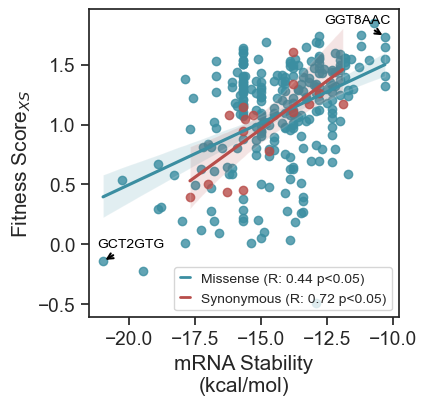

In [35]:
EXP = "low"
output, missense, synonymous = csv_read(EXP, terminus = "N", notstop = True)
sns.set(font_scale=1.25, font="Arial", rc={'figure.figsize': (4, 4)}, style="ticks")
# Create scatter plot
sns.regplot(data=missense, x="mrna_stability", y="norm_score", color = palette[0])
sns.regplot(data=synonymous, x="mrna_stability", y="norm_score", color = palette[1])
point_min = output[output["variant"] == "GGT8AAC"].iloc[0]  # Get the first matching row
plt.annotate("GGT8AAC", 
             xy=(point_min["mrna_stability"], point_min["norm_score"]),  # Point to annotate
             textcoords="offset points",  # How to position the text
             xytext=(-20, 10),  # Offset in points (x, y)
             ha='center',  # Horizontal alignment
             fontsize=10,  # Font size of annotation
             color="black",  # Color of the annotation text
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))  # Arrow properties
point_max = output[output["variant"] == "GCT2GTG"].iloc[0]  # Get the first matching row
plt.annotate("GCT2GTG", 
             xy=(point_max["mrna_stability"], point_max["norm_score"]),  # Point to annotate
             textcoords="offset points",  # How to position the text
             xytext=(20, 10),  # Offset in points (x, y)
             ha='center',  # Horizontal alignment
             fontsize=10,  # Font size of annotation
             color="black",  # Color of the annotation text
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))  # Arrow properties
if EXP =="low":
    plt.ylabel("Fitness Score$_{XS}$")
if EXP =="high":
    plt.ylabel("Fitness Score$_{XL}$")    
plt.xlabel("mRNA Stability" + "\n" + "(kcal/mol)")
#----------------
miss_r = n_corr[n_corr["dataset"]==f"{EXP}_miss"]["r_value"].values[0]
syn_r = n_corr[n_corr["dataset"]==f"{EXP}_syn"]["r_value"].values[0]
handles = [Line2D([0], [0], color=palette[0], lw=2), Line2D([0], [0], color=palette[1], lw=2)]
plt.legend(handles=handles,
           labels=[f"Missense (R: {miss_r})", f"Synonymous (R: {syn_r})"],
           loc="lower right", handlelength=0.75, fontsize = 10)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

In [36]:
c_corr = pd.DataFrame({
    "dataset": ["low_miss", "low_syn", "high_miss", "high_syn"],
    "terminus": ["C", "C", "C", "C"],
    "r_value": ["0.08 p: 0.24", "0.37 p: 0.37", "0.07 p: 0.27","-0.04 p: 0.92"],
    "p_value": [0.2358184755320586, 0.3727328935902777, 0.265557008974192, 0.9177291865101278]
})

notstop
terminus: C
dataset: high


(-27.5, -7.5)

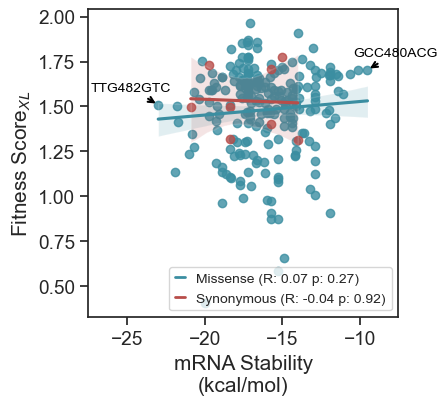

In [38]:
EXP = "high"
output, missense, synonymous = csv_read(EXP, terminus = "C", notstop = True)
sns.set(font_scale=1.25, font="Arial", rc={'figure.figsize': (4, 4)}, style="ticks")
# Create scatter plot
sns.regplot(data=missense, x="mrna_stability", y="norm_score", color = palette[0])
sns.regplot(data=synonymous, x="mrna_stability", y="norm_score", color = palette[1])
point_min = output[output["variant"] == "TTG482GTC"].iloc[0]  # Get the first matching row
plt.annotate("TTG482GTC", 
             xy=(point_min["mrna_stability"], point_min["norm_score"]),  # Point to annotate
             textcoords="offset points",  # How to position the text
             xytext=(-20, 10),  # Offset in points (x, y)
             ha='center',  # Horizontal alignment
             fontsize=10,  # Font size of annotation
             color="black",  # Color of the annotation text
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))  # Arrow properties
point_max = output[output["variant"] == "GCC480ACG"].iloc[0]  # Get the first matching row
plt.annotate("GCC480ACG", 
             xy=(point_max["mrna_stability"], point_max["norm_score"]),  # Point to annotate
             textcoords="offset points",  # How to position the text
             xytext=(20, 10),  # Offset in points (x, y)
             ha='center',  # Horizontal alignment
             fontsize=10,  # Font size of annotation
             color="black",  # Color of the annotation text
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))  # Arrow properties
if EXP =="low":
    plt.ylabel("Fitness Score$_{XS}$")
if EXP =="high":
    plt.ylabel("Fitness Score$_{XL}$")    
plt.xlabel("mRNA Stability" + "\n" + "(kcal/mol)")
#----------------
miss_r = c_corr[c_corr["dataset"]==f"{EXP}_miss"]["r_value"].values[0]
syn_r = c_corr[c_corr["dataset"]==f"{EXP}_syn"]["r_value"].values[0]
handles = [Line2D([0], [0], color=palette[0], lw=2), Line2D([0], [0], color=palette[1], lw=2)]
plt.legend(handles=handles,
           labels=[f"Missense (R: {miss_r})", f"Synonymous (R: {syn_r})"],
           loc="lower right", handlelength=0.75, fontsize = 10)
plt.xlim(-27.5, -7.5)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()